For this project, we selected Python to be the tool/language. So, the first step is loading the pip packages required:

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits import mplot3d
import warnings
warnings.filterwarnings("ignore")
from IPython.display import clear_output

We start by generating a set with 500 3-D points, as required, using numpy, to be using while developing the functions to be used in the main goal of the project. We convert it to Pandas DataFrame to take advantage of several functions embedded on a DataFrame for processing data.

In [2]:
test = np.random.randint(0, 100, size=(500, 3))
test = pd.DataFrame(test, columns = ["x", "y", "z"])
test.head()

,x,y,z
0,84,60,18
1,53,82,8
2,49,56,61
3,46,5,35
4,91,13,11


We plot the data to check how it looks like

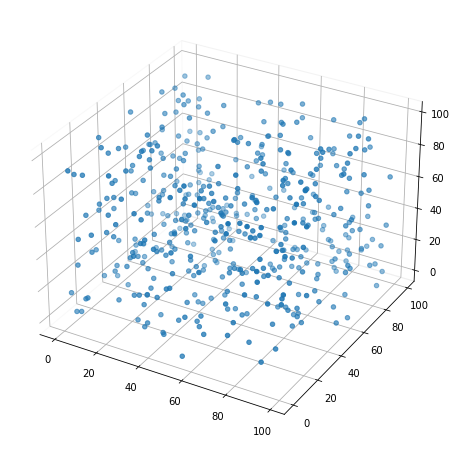

In [3]:
fig = plt.figure(figsize = (16, 8))
ax = plt.axes(projection ="3d")
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
my_cmap = plt.get_cmap("gist_rainbow_r")
ax.scatter3D(test["x"], test["y"], test["z"])

We now create some functions that will be used throughout the project. Let's start with a function that calculates the Euclidean distance. This function receives:

* **from_data_point**: a 3-D vector containing the initial data point from where the distance will be calculated
* **to_data_point**: a 3-D vector containing the final data point to where the distance will be calculated

and then it returns the distance between the two data points

**Note**: we are calling from and to just to differentiate the two arguments, as the distance on both ways are the same

In [4]:
def calculate_euclidean_distance(from_data_point, to_data_point):
    return math.sqrt(
            (from_data_point[0] - to_data_point[0]) ** 2 + 
            (from_data_point[1] - to_data_point[1]) ** 2 + 
            (from_data_point[2] - to_data_point[2]) ** 2
    )

calculate_euclidean_distance(test.iloc[:1].values.flatten(), [0, 0, 0])

104.78549517943789

Let's test for all of the 500 points generated, using the center of the space that generated the points.

In [5]:
test.apply(lambda row: calculate_euclidean_distance(row.values.flatten(), [50, 50, 50]), axis = 1)

0      47.749346
1      52.886671
2      12.569805
3      47.602521
4      67.609171
         ...    
495    32.588341
496    56.833089
497    46.400431
498    62.521996
499    58.966092
Length: 500, dtype: float64

The second function we create is to calculate the center of a cluster. This function receives:

* **cluster**: a list of 3-D vectors

and will return the cluster centroid

In [6]:
def calculate_centroid(cluster):
    centroid = [
        sum([x[0] for x in cluster]) / len(cluster),
        sum([y[1] for y in cluster]) / len(cluster),
        sum([z[2] for z in cluster]) / len(cluster)
    ]
    
    return centroid
    
calculate_centroid([[0, 0, 0], [100, 100, 100]])

[50.0, 50.0, 50.0]

Let's test this function for the DataFrame with our data points

In [7]:
calculate_centroid(test.values.tolist())

[49.918, 50.274, 48.944]

The third function that we create is to calculate the distance between two clusters. This function receives:

* **from_data_points**: a list containing 3-D vector for the initial data points from where the distance will be calculated
* **to_data_points**: a list containing 3-D vectors for the final points to where the distance will be calculated
* **distance_type**: a parameter determining the type of distance (min, max, avg and center) that will be used for the calculation

and returns the distance between two sets of datapoints (even "sets" with only one datapoint), according to the type specified

In [8]:
from_data_points = [[0, 0, 0], [15, 15, 15], [100, 100, 100]]
to_data_points = [[10, 10, 10], [1, 1, 1], [50, 50, 50]]
def find_cluster_distance(from_data_points, to_data_points, type = "min"):
    distance = 0.00
    if type == "center":
        distance = calculate_euclidean_distance(
            calculate_centroid(from_data_points), 
            calculate_centroid(to_data_points)
        )
    else:
        li = []
        for each_from in from_data_points:
            for each_to in to_data_points:
                li.append(calculate_euclidean_distance(each_from, each_to)) 
        if len(li) == 0:
            distance = 0
        elif type == "min":
            distance = min(li)
        elif type == "max":
            distance = max(li)
        elif type == "avg":
            distance = sum(li) / len(li)

    return distance

print("Distance between centroids:", find_cluster_distance(from_data_points, to_data_points, type="center"))
print("Minimum distance:", find_cluster_distance(from_data_points, to_data_points, type="min"))
print("Maximum distance:", find_cluster_distance(from_data_points, to_data_points, type="max"))
print("Average distance:", find_cluster_distance(from_data_points, to_data_points, type="avg"))

Distance between centroids: 31.176914536239796
Minimum distance: 1.7320508075688772
Maximum distance: 171.47302994931886
Average distance: 68.12733176437584


Let's test this function for the DataFrame with our data points

In [9]:
print(find_cluster_distance(test.values.tolist(), test.values.tolist(), type = "center"))
print(find_cluster_distance(test.values.tolist(), test.values.tolist(), type = "min"))
print(find_cluster_distance(test.values.tolist(), test.values.tolist(), type = "max"))
print(find_cluster_distance(test.values.tolist(), test.values.tolist(), type = "avg"))

0.0
0.0
158.8049117628293
67.3120533118686


# Outlier detection

For outlier detection, we implement the **Distance-Based Outlier Detection** using the **Nested Loop Method** as described in chapter 12.4.1 of **Data Mining: Concepts and Techniques** coursebook. We construct a function that receives:

* **data_points**: a list of 3-D vectors containing all datapoints
* **d_distance**: the distance threshold to be used
* **p_fraction**: the fraction of neighbors to be considered in the radius

and returns a list with all datapoints and a flag (True/False) of that datapoint being a potential outlier

In [10]:
test_list = test.copy().values.tolist()

def DB_outlier_detection(data_points, d_distance = 100, p_fraction = 0.1):
    li = []

    for i in range(0, len(data_points)):
        count = 0
        is_outlier = True
        for j in range(0, len(data_points)):
            distance = find_cluster_distance([data_points[i]], [data_points[j]], type = "min")
            if (i != j) & (distance <= d_distance):
                count += 1
                if count >= p_fraction * len(data_points): 
                    is_outlier = False
        li.append([data_points[i], is_outlier])
    return li

outliers = pd.DataFrame(DB_outlier_detection(test_list), columns = ["coordinates", "potential_outlier"])
outliers

,coordinates,potential_outlier
0,"[84, 60, 18]",False
1,"[53, 82, 8]",False
2,"[49, 56, 61]",False
3,"[46, 5, 35]",False
4,"[91, 13, 11]",False
...,...,...
495,"[24, 45, 69]",False
496,"[99, 23, 40]",False
497,"[30, 77, 82]",False
498,"[6, 27, 88]",False


We run again, but now reducing the d (distance) and increasing p (fraction) parameters to generate some outliers. In order to visually inspect the results, we converted the list into a Pandas DataFrame and then transform and add columns in order to plot the results

In [11]:
outliers = DB_outlier_detection(test_list, d_distance = 50, p_fraction = 0.15)
outliers = pd.DataFrame(outliers, columns = ["coordinates", "potential_outlier"])
outliers["coordinates_str"] = [','.join(map(str, l)) for l in outliers["coordinates"]]
outliers[["x", "y", "z"]] = outliers["coordinates_str"].str.split(",", expand=True)
outliers[["x", "y", "z"]] = outliers[["x", "y", "z"]].apply(pd.to_numeric)
outliers = outliers[["x", "y", "z", "potential_outlier"]]
outliers["color"] = outliers["potential_outlier"].apply(lambda row: "Red" if row else "Blue")

outliers.tail()

,x,y,z,potential_outlier,color
495,24,45,69,False,Blue
496,99,23,40,False,Blue
497,30,77,82,False,Blue
498,6,27,88,False,Blue
499,10,64,91,False,Blue


Now we can plot the results

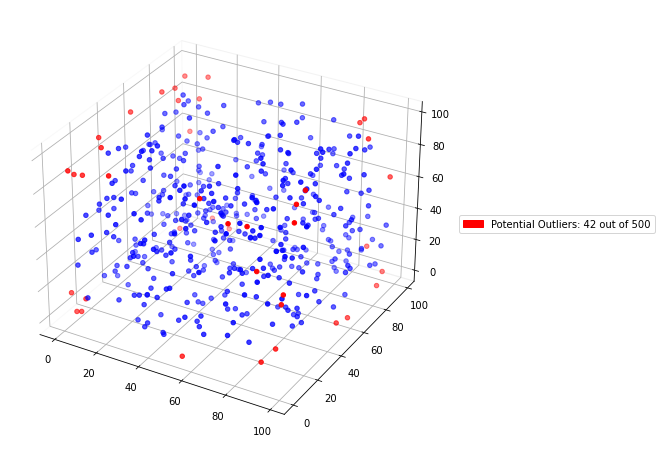

In [12]:
fig = plt.figure(figsize = (16, 8))
ax = plt.axes(projection ="3d")
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.scatter3D(outliers["x"], outliers["y"], outliers["z"], facecolors = outliers["color"])
outlier_label = (
    "Potential Outliers: " + 
    str(len(outliers[outliers["potential_outlier"] == True])) + 
    " out of " + 
    str(len(outliers))
)
red_patch = mpatches.Patch(color="red", label=outlier_label)
ax.legend(handles=[red_patch], bbox_to_anchor=(1.5, .5), loc="center right")

We have attempted several combinations for distance and fraction of neighbors and came to the conclusion that the best minimum distance to be used for this dataset was 50 while the fractions between 0.11 and 0.15 were the ones that best "tagged" potential outliers. We are going to use d = 50 and p = 0.15 for now on

Finally, we create a function to remove the outliers of a dataset (Pandas DataFrame). This function receives:

* **data_points**: a Pandas DataFrame contaning 3 columns (x, y and z), each one with one of the coordinates for the data points
* **d_distance**: the distance threshold to be used
* **p_fraction**: the fraction of neighbors to be considered in the radius

and returns the Pandas DataFrame without the outliers according to the parameters informed

In [13]:
def remove_outliers(data_points, d_distance = 100, p_fraction = 0.1):
    datapoints_list = data_points.copy().values.tolist()
    outliers = DB_outlier_detection(datapoints_list, d_distance = 50, p_fraction = 0.15)
    outliers = pd.DataFrame(outliers, columns = ["coordinates", "potential_outlier"])
    outliers["coordinates_str"] = [','.join(map(str, l)) for l in outliers["coordinates"]]
    outliers[["x", "y", "z"]] = outliers["coordinates_str"].str.split(",", expand=True)
    outliers[["x", "y", "z"]] = outliers[["x", "y", "z"]].apply(pd.to_numeric)
    outliers = outliers[["x", "y", "z", "potential_outlier"]]
    outliers.merge(data_points)
    outliers = outliers[outliers["potential_outlier"] == False]
    
    return outliers
    
test_without_outliers = remove_outliers(test.copy(), d_distance = 50, p_fraction = 0.15)
test_without_outliers

,x,y,z,potential_outlier
0,84,60,18,False
1,53,82,8,False
2,49,56,61,False
3,46,5,35,False
5,74,89,19,False
...,...,...,...,...
495,24,45,69,False
496,99,23,40,False
497,30,77,82,False
498,6,27,88,False


As we can see above, the outliers previously detected were removed from the final DataFrame

# K-means

Now we implement the K-means. But before that, we implement a function to find the closest coordinate of a Data Point. We use this to assign the data point to the closest cluster. This function receives:

* **coordinates**: the 3-D coordinates of a data point
* **clusters**: a list of 3-D coordinates of clusters
* **type**: the type of distance (center, min, max or avg) to be used when calculating the distance and determining the nearest cluster

and outputs the item from the list of clusters that is closest according to "type" criteria defined

In [14]:
def find_closest_cluster(coordinates, clusters, type = "min"):
    li = []
    for each_cluster in clusters:
        distance = find_cluster_distance(coordinates, [each_cluster], type = "min")
        li.append(distance)
    
    return clusters[li.index(min(li))]
    
coordinates = test_without_outliers.copy().iloc[:1][["x", "y", "z"]].values.tolist()
print(coordinates)
find_closest_cluster(coordinates, [[0, 0, 0], [100, 100, 100]])

[[84, 60, 18]]


[100, 100, 100]

Finally, we create the function that implement the K-means algorithm. This function receives:

* **data_points**: the data points to be clustered as a Pandas DataFrame
* **k**: the number of clusters to be generated

and returns the Pandas DataFrame with three additional columns (cx, cz and cy) containing the coordinates of the centroid of the cluster the data point is assigned to. It also prints the number of iterations required to converge

**Note**: the function picks the initial centroids randomly

In [15]:
test_without_outliers = remove_outliers(test.copy(), d_distance = 50, p_fraction = 0.15)

def k_means(data_points, k=10):
    current_centroids = np.zeros((k, 3)).tolist()
    centroids = np.random.randint(0, 100, size=(k, 3)).tolist()
    counter = 1

    while current_centroids != centroids:
        current_centroids = centroids
        # Assign data points to centroids
        data_points["nearest"] = data_points.apply(
            lambda row: find_closest_cluster(
                [[row.x, row.y, row.z]], 
                centroids, 
                type = "min"), 
            axis = 1)

        data_points["cluster"] = data_points["nearest"].astype(str)

        # Re-calculate the centroids
        centroids = data_points[["cluster", "x", "y", "z"]].groupby(["cluster"]).mean()
        centroids = centroids[["x", "y", "z"]].values.tolist()

        counter += 1
    print(f"Number of iterations needed to converge to {k} clusters:", counter)
    
    data_points["cluster"] = data_points["cluster"].str.replace("\[|\]", "", regex=True)
    data_points[["cx", "cy", "cz"]] = data_points["cluster"].str.split(",", expand=True)
    data_points[["cx", "cy", "cz"]] = data_points[["cx", "cy", "cz"]].apply(pd.to_numeric)
    return data_points.drop(["nearest", "cluster"], axis=1)

k_means(test_without_outliers.copy(), 10)

Number of iterations needed to converge to 10 clusters: 11


,x,y,z,potential_outlier,cx,cy,cz
0,84,60,18,False,77.253968,79.047619,21.809524
1,53,82,8,False,77.253968,79.047619,21.809524
2,49,56,61,False,52.515152,50.363636,52.393939
3,46,5,35,False,40.952381,22.880952,14.833333
5,74,89,19,False,77.253968,79.047619,21.809524
...,...,...,...,...,...,...,...
495,24,45,69,False,16.588235,53.843137,78.411765
496,99,23,40,False,79.421053,29.289474,27.684211
497,30,77,82,False,16.588235,53.843137,78.411765
498,6,27,88,False,16.588235,53.843137,78.411765


To check how K-means accommodated the data points into clusters, let's first see how many datapoints are contained in each cluster

In [16]:
test_kmeans = k_means(test_without_outliers.copy(), 10)
test_kmeans[["cx", "cy", "cz", "potential_outlier"]].groupby(["cx", "cy", "cz"]).count()

Number of iterations needed to converge to 10 clusters: 24


,,,potential_outlier
cx,cy,cz,
15.850000,64.800000,72.725000,40
19.341463,27.609756,25.048780,41
20.475000,19.800000,70.050000,40
25.706897,72.965517,26.620690,58
48.368421,27.131579,15.947368,38
54.166667,78.583333,78.611111,36
60.450980,26.901961,75.411765,51
76.772727,77.424242,20.818182,66
80.146341,27.195122,37.048780,41


And we also can plot it

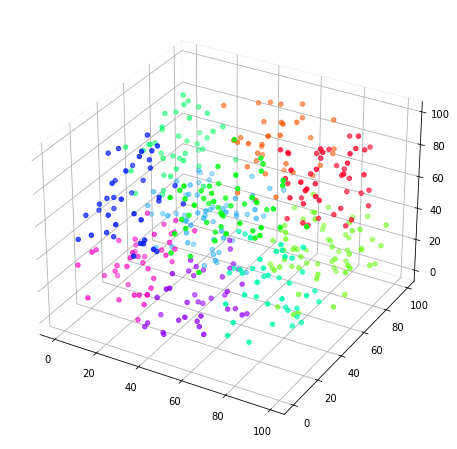

In [17]:
fig = plt.figure(figsize = (16, 8))
ax = plt.axes(projection ="3d")
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
my_cmap = plt.get_cmap("gist_rainbow_r")
ax.scatter3D(test_kmeans["x"], test_kmeans["y"], test_kmeans["z"], 
             cmap = my_cmap, c = (test_kmeans["cy"] + test_kmeans["cz"] + test_kmeans["cx"])) 

# Silhouette coefficient

Next, we implement the silhouette coefficient algorithm. To implement and test it, we used the example provided during the respective lecture to make sure the calculations are matching. So, first we create a Pandas DataFrame with those data points and the respective cluster centroids coordinates as per the lecture

In [18]:
c1 = [[5, 16, 0], [8, 13, 0], [8, 10, 0], [5, 9, 0]]
c1 = pd.DataFrame(c1, columns=["x", "y", "z"], index=[1, 2, 3, 4])
c1["cluster"] = c1[["x", "y", "z"]].apply(lambda row: calculate_centroid(c1.values.tolist()), axis = 1)
c1["coordinates_str"] = [','.join(map(str, l)) for l in c1["cluster"]]
c1[["cx", "cy", "cz"]] = c1["coordinates_str"].str.split(",", expand=True)
c1[["x", "y", "z"]] = c1[["x", "y", "z"]].apply(pd.to_numeric)
c1 = c1[["x", "y", "z", "cx", "cy", "cz"]]

c2 = [[14, 16, 0], [18, 17, 0]]
c2 = pd.DataFrame(c2, columns=["x", "y", "z"], index=[5, 6])
c2["cluster"] = c2[["x", "y", "z"]].apply(lambda row: calculate_centroid(c2.values.tolist()), axis = 1)
c2["coordinates_str"] = [','.join(map(str, l)) for l in c2["cluster"]]
c2[["cx", "cy", "cz"]] = c2["coordinates_str"].str.split(",", expand=True)
c2[["x", "y", "z"]] = c2[["x", "y", "z"]].apply(pd.to_numeric)
c2 = c2[["x", "y", "z", "cx", "cy", "cz"]]

c3 = [[10, 3, 0], [12, 5, 0], [16, 7, 0], [16, 11, 0]]
c3 = pd.DataFrame(c3, columns=["x", "y", "z"], index=[7, 8, 9, 10])
c3["cluster"] = c3[["x", "y", "z"]].apply(lambda row: calculate_centroid(c3.values.tolist()), axis = 1)
c3["coordinates_str"] = [','.join(map(str, l)) for l in c3["cluster"]]
c3[["cx", "cy", "cz"]] = c3["coordinates_str"].str.split(",", expand=True)
c3[["x", "y", "z"]] = c3[["x", "y", "z"]].apply(pd.to_numeric)
c3 = c3[["x", "y", "z", "cx", "cy", "cz"]]
all_clusters = pd.concat([c1, c2, c3])
all_clusters

,x,y,z,cx,cy,cz
1,5,16,0,6.5,12.0,0.0
2,8,13,0,6.5,12.0,0.0
3,8,10,0,6.5,12.0,0.0
4,5,9,0,6.5,12.0,0.0
5,14,16,0,16.0,16.5,0.0
6,18,17,0,16.0,16.5,0.0
7,10,3,0,13.5,6.5,0.0
8,12,5,0,13.5,6.5,0.0
9,16,7,0,13.5,6.5,0.0
10,16,11,0,13.5,6.5,0.0


Now we define the calculate_silhouette function. It receives:
    
* **data_points**: a Pandas DataFrame containing the coordinates of each data point (on columns x, y and z) and the coordinates of their cluster's respective centroids (on columns cx, cz and cy)

and returns a Pandas DataFrame with one additional column containing the silhouette coefficient of that data point

In [19]:
def calculate_silhouette(data_points):
    intra = []
    for i, each_point in data_points.iterrows():
        neighbors = data_points
        neighbors = neighbors.drop(i)
        neighbors = neighbors[(neighbors["cx"] == each_point["cx"]) & 
                              (neighbors["cy"] == each_point["cy"]) & 
                              (neighbors["cz"] == each_point["cz"])]
        intra_cluster = find_cluster_distance(
            [each_point.values.tolist()], neighbors.values.tolist(), type = "avg")

        other_clusters = data_points
        other_clusters = other_clusters[~((other_clusters["cx"] == each_point["cx"]) & 
                                          (other_clusters["cy"] == each_point["cy"]) & 
                                          (other_clusters["cz"] == each_point["cz"]))]    
        other_clusters = (other_clusters[["cx", "cy", "cz"]]).drop_duplicates()
        inter = []
        for j, each_non_neighbors in other_clusters.iterrows():
            non_neighbors = data_points
            non_neighbors = non_neighbors[(non_neighbors["cx"] == each_non_neighbors["cx"]) & 
                                          (non_neighbors["cy"] == each_non_neighbors["cy"]) & 
                                          (non_neighbors["cz"] == each_non_neighbors["cz"])]
            non_neighbors = non_neighbors[["x", "y", "z"]]
            inter_cluster = find_cluster_distance(
                [each_point.values.tolist()], non_neighbors.values.tolist(), type = "avg")
            inter.append(inter_cluster)   

        b1 = min(inter)
        s1 = (b1 - intra_cluster) / max(intra_cluster, b1)
        intra.append({
                "index": i,
                "silhouette_coeficient": s1
            }
        )
    return pd.concat([data_points, pd.DataFrame(intra).set_index("index")], axis=1)

calculate_silhouette(all_clusters.copy())

,x,y,z,cx,cy,cz,silhouette_coeficient
1,5,16,0,6.5,12.0,0.0,0.456983
2,8,13,0,6.5,12.0,0.0,0.533041
3,8,10,0,6.5,12.0,0.0,0.433446
4,5,9,0,6.5,12.0,0.0,0.471235
5,14,16,0,16.0,16.5,0.0,0.536668
6,18,17,0,16.0,16.5,0.0,0.641963
7,10,3,0,13.5,6.5,0.0,0.318675
8,12,5,0,13.5,6.5,0.0,0.469138
9,16,7,0,13.5,6.5,0.0,0.461545
10,16,11,0,13.5,6.5,0.0,-0.171916


Let's check with the last cluster we generated using K-means algorithm

In [20]:
test_kmeans_silhouette = calculate_silhouette(test_kmeans.copy())
test_kmeans_silhouette.tail()

,x,y,z,potential_outlier,cx,cy,cz,silhouette_coeficient
495,24,45,69,False,15.850000,64.800000,72.72500,0.120282
496,99,23,40,False,80.146341,27.195122,37.04878,0.472482
497,30,77,82,False,15.850000,64.800000,72.72500,0.107144
498,6,27,88,False,20.475000,19.800000,70.05000,0.305133
499,10,64,91,False,15.850000,64.800000,72.72500,0.482126


We can also get the average silhouette for the whole clustering:

In [21]:
sum(test_kmeans_silhouette["silhouette_coeficient"]) / len(test_kmeans_silhouette.index)

0.27357434620584287

As an exercise, let's calculate the coefficient for a range of K values between 5 and 15, to check which one of them has the higher value (towards 1)

In [22]:
li = []
initial_k, final_k = 5, 15
for k in range(initial_k, final_k + 1):
    check_best_k = k_means(test_without_outliers.copy(), k)
    k_silhouette = calculate_silhouette(check_best_k.copy())
    row = {
        "k": k,
        "silhouette": sum(k_silhouette["silhouette_coeficient"]) / len(k_silhouette.index)
    }
    li.append(row)

Number of iterations needed to converge to 5 clusters: 11
Number of iterations needed to converge to 6 clusters: 25
Number of iterations needed to converge to 7 clusters: 21
Number of iterations needed to converge to 8 clusters: 14
Number of iterations needed to converge to 9 clusters: 19
Number of iterations needed to converge to 10 clusters: 17
Number of iterations needed to converge to 11 clusters: 14
Number of iterations needed to converge to 12 clusters: 17
Number of iterations needed to converge to 13 clusters: 21
Number of iterations needed to converge to 14 clusters: 14
Number of iterations needed to converge to 15 clusters: 14


In [23]:
silhouette_coefs = pd.DataFrame(li)
silhouette_coefs.sort_values(by=["silhouette"], ascending=False).head()

,k,silhouette
1,6,0.299883
0,5,0.291459
3,8,0.288892
6,11,0.284817
4,9,0.283399


We can see above that the best K for the current data points is 6. However, as we will be generating the data points randomly when comparing it with hierarchical agglomerative clustering, we will keep using K=10. We could develop a function to check the best K and then use it, but as it would demand long time to run, especially on agglomerative clustering, we are not doing it (even because we should already compare with different distance types for agglomerative)

We also plot the values on a chart:

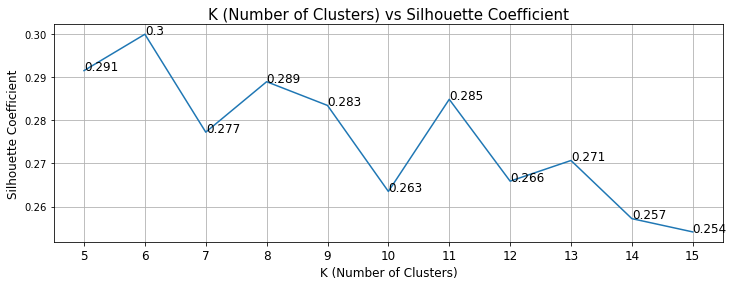

In [24]:
fig, ax = plt.subplots(figsize=(12, 4))
x = silhouette_coefs["k"]
y = silhouette_coefs["silhouette"]
plt.plot(x, y)
plt.xlabel("K (Number of Clusters)", size=12)
plt.ylabel("Silhouette Coefficient", size=12)
plt.title("K (Number of Clusters) vs Silhouette Coefficient", size=15)
for index in range(len(x)):
    ax.text(x[index], y[index], round(y[index], 3), size=12)
plt.xticks(x, size=12)
plt.grid()
plt.show()

# Hierarchical Agglomerative Clustering

Now we implement the Hierarchical Agglomerative Clustering algorithm. We have tested several implementations, but as we need to keep calculating the distance between every cluster after each agglomeration, it was taking a lot of time to process for 500 (minus the outliers) data points. One way of solving that was to store the distances into a Pandas DataFrame. 

So, first we initialize the **distances** DataFrame, considering each individual point as one cluster, and then we keep deleting distances for data points/clusters that were just agglomerated and then adding the distances for the new cluster in relation to any other cluster/data point. The function that initializes the distances receives:

* **initial_data_points**: a Pandas DataFrame containing all the initial data points

and outputs a Pandas DataFrame with the distances between each individual data point

In [25]:
test_hierarchical = remove_outliers(test.copy(), d_distance = 50, p_fraction = 0.15)
initial_data_points = test_hierarchical.copy()

def initialize_distances(initial_data_points):
    distances = pd.DataFrame()
    for i, each_from in initial_data_points.iterrows():
        initial_data_points.drop(index = i, inplace=True)
        for j, each_to in initial_data_points.iterrows():
            distances = distances.append(
                {
                    "cx1": each_from["x"],
                    "cy1": each_from["y"],
                    "cz1": each_from["z"],
                    "cx2": each_to["x"],
                    "cy2": each_to["y"],
                    "cz2": each_to["z"]
                }, ignore_index = True
            )
    distances["distance"] = distances.apply(lambda row: calculate_euclidean_distance(
        row[["cx1", "cy1", "cz1"]].values.flatten(), 
        row[["cx2", "cy2", "cz2"]].values.flatten()), axis = 1)
    return distances

distances = initialize_distances(initial_data_points.copy().head(10))
distances.head()

,cx1,cy1,cz1,cx2,cy2,cz2,distance
0,84,60,18,53,82,8,39.306488
1,84,60,18,49,56,61,55.587768
2,84,60,18,46,5,35,68.978257
3,84,60,18,74,89,19,30.692019
4,84,60,18,28,42,45,64.722485


And now we implement the Hierarchical Agglomerative Cluster on a function that receives:

* **data_points**: a Pandas DataFrame with all data points
* **k**: the number of clusters to be generated
* **distance_type**: the distance type (min, max, avg or center) to be used when calculating the distance between two clusters
* **distances**: the distances Pandas DataFrame with the initial distances. If this argument is not provided, the function initializes the distances DataFrame

as in the K-means function, it returns the Pandas DataFrame with three additional columns (cx, cz and cy) containing the coordinates of the centroid of the cluster the data point is assigned to

Just for the sake of having an idea on how the processing is going, we also print the step it is performing (cleaning the screen before)

In [26]:
def hierarchical_agglomerative(data_points, k=10, distance_type = "min", distances = None):
    # First we define each point belonging to its own "cluster"
    data_points["cx"] = data_points["x"]
    data_points["cy"] = data_points["y"]
    data_points["cz"] = data_points["z"]

    if distances is None:
        distances = initialize_distances(data_points.copy())

    # Agglomerate while the number of clusters is greater than k
    while len((data_points[["cx", "cy", "cz"]]).drop_duplicates().index) > k:
        clear_output(wait=True)
        print("Agglomerating to", 
              len((data_points[["cx", "cy", "cz"]]).drop_duplicates().index) - 1, 
              f"clusters using {distance_type} distance")
        
        shortest_distance_index = distances.sort_values(by=["distance"]).index[0]
        
        to_merge = data_points[((data_points["cx"] == distances.at[shortest_distance_index, "cx1"]) & 
                          (data_points["cy"] == distances.at[shortest_distance_index, "cy1"]) & 
                          (data_points["cz"] == distances.at[shortest_distance_index, "cz1"])) |
                          ((data_points["cx"] == distances.at[shortest_distance_index, "cx2"]) & 
                          (data_points["cy"] == distances.at[shortest_distance_index, "cy2"]) & 
                          (data_points["cz"] == distances.at[shortest_distance_index, "cz2"]))
                         ]
        
        for i, each_point_to_merge in to_merge.iterrows():
            distances_to_remove = distances[
                             ((distances["cx1"] == each_point_to_merge["cx"]) & 
                              (distances["cy1"] == each_point_to_merge["cy"]) & 
                              (distances["cz1"] == each_point_to_merge["cz"])) |
                              ((distances["cx2"] == each_point_to_merge["cx"]) & 
                              (distances["cy2"] == each_point_to_merge["cy"]) & 
                              (distances["cz2"] == each_point_to_merge["cz"]))
                            ]  
            distances.drop(distances_to_remove.index, inplace = True)
        
        data_points.loc[to_merge.index, ["cx"]] = to_merge["x"].mean()
        data_points.loc[to_merge.index, ["cy"]] = to_merge["y"].mean()
        data_points.loc[to_merge.index, ["cz"]] = to_merge["z"].mean()        
                           
        other_clusters = data_points.copy()
        other_clusters.drop(index=to_merge.index, inplace=True)
       
        other_clusters = (other_clusters[["cx", "cy", "cz"]]).drop_duplicates()
        for j, each_non_neighbors in other_clusters.iterrows():
            non_neighbors = data_points.copy()
            non_neighbors = non_neighbors[(non_neighbors["cx"] == each_non_neighbors["cx"]) & 
                                          (non_neighbors["cy"] == each_non_neighbors["cy"]) & 
                                          (non_neighbors["cz"] == each_non_neighbors["cz"])]            
            cluster_distance = find_cluster_distance(
                to_merge[["x", "y", "z"]].values.tolist(), non_neighbors.values.tolist(), type = distance_type)

            distances = distances.append(
                {
                    "cx1": to_merge["x"].mean(),
                    "cy1": to_merge["y"].mean(),
                    "cz1": to_merge["z"].mean(),
                    "cx2": each_non_neighbors["cx"],
                    "cy2": each_non_neighbors["cy"],
                    "cz2": each_non_neighbors["cz"],
                    "distance": cluster_distance
                }, ignore_index = True
            )                             

    return data_points

k = 2
test_hierarchical = remove_outliers(test.copy(), d_distance = 50, p_fraction = 0.15)
clusterized_hierarchical = hierarchical_agglomerative(test_hierarchical.copy().head(10), k, distance_type = "min")
clusterized_hierarchical

Agglomerating to 2 clusters using min distance


,x,y,z,potential_outlier,cx,cy,cz
0,84,60,18,False,52.222222,49.333333,38.0
1,53,82,8,False,52.222222,49.333333,38.0
2,49,56,61,False,52.222222,49.333333,38.0
3,46,5,35,False,52.222222,49.333333,38.0
5,74,89,19,False,52.222222,49.333333,38.0
6,28,42,45,False,52.222222,49.333333,38.0
7,31,12,14,False,52.222222,49.333333,38.0
8,93,16,66,False,93.000000,16.000000,66.0
9,56,45,47,False,52.222222,49.333333,38.0
11,49,53,95,False,52.222222,49.333333,38.0


Let's check how this small clustering looks like

In [27]:
clusterized_hierarchical[["cx", "cy", "cz", "potential_outlier"]].groupby(["cx", "cy", "cz"]).count()

,,,potential_outlier
cx,cy,cz,
52.222222,49.333333,38.0,9
93.000000,16.000000,66.0,1


Now let's test the function but using distances DataFrame already calculated (this will be valuable when comparing for different distance types later) and for the four types of distance

In [28]:
distances = initialize_distances(test_hierarchical.copy().head(10))
distances.head()

,cx1,cy1,cz1,cx2,cy2,cz2,distance
0,84,60,18,53,82,8,39.306488
1,84,60,18,49,56,61,55.587768
2,84,60,18,46,5,35,68.978257
3,84,60,18,74,89,19,30.692019
4,84,60,18,28,42,45,64.722485


Starting with min distance

In [29]:
k = 2
test_hierarchical = remove_outliers(test.copy(), d_distance = 50, p_fraction = 0.15)
hierarchical_agglomerative(test_hierarchical.head(10), k, distance_type = "min", 
                           distances = distances.copy())

Agglomerating to 2 clusters using min distance


,x,y,z,potential_outlier,cx,cy,cz
0,84,60,18,False,52.222222,49.333333,38.0
1,53,82,8,False,52.222222,49.333333,38.0
2,49,56,61,False,52.222222,49.333333,38.0
3,46,5,35,False,52.222222,49.333333,38.0
5,74,89,19,False,52.222222,49.333333,38.0
6,28,42,45,False,52.222222,49.333333,38.0
7,31,12,14,False,52.222222,49.333333,38.0
8,93,16,66,False,93.000000,16.000000,66.0
9,56,45,47,False,52.222222,49.333333,38.0
11,49,53,95,False,52.222222,49.333333,38.0


Using max distance

In [30]:
hierarchical_agglomerative(test_hierarchical.copy().head(10), 2, distance_type = "max", 
                           distances = distances.copy())

Agglomerating to 2 clusters using max distance


,x,y,z,potential_outlier,cx,cy,cz
0,84,60,18,False,57.6,49.6,18.8
1,53,82,8,False,57.6,49.6,18.8
2,49,56,61,False,55.0,42.4,62.8
3,46,5,35,False,57.6,49.6,18.8
5,74,89,19,False,57.6,49.6,18.8
6,28,42,45,False,55.0,42.4,62.8
7,31,12,14,False,57.6,49.6,18.8
8,93,16,66,False,55.0,42.4,62.8
9,56,45,47,False,55.0,42.4,62.8
11,49,53,95,False,55.0,42.4,62.8


Using average distance

In [31]:
hierarchical_agglomerative(test_hierarchical.copy().head(10), 2, distance_type = "avg", 
                           distances = distances.copy())

Agglomerating to 2 clusters using avg distance


,x,y,z,potential_outlier,cx,cy,cz
0,84,60,18,False,70.333333,77.000000,15.000000
1,53,82,8,False,70.333333,77.000000,15.000000
2,49,56,61,False,50.285714,32.714286,51.857143
3,46,5,35,False,50.285714,32.714286,51.857143
5,74,89,19,False,70.333333,77.000000,15.000000
6,28,42,45,False,50.285714,32.714286,51.857143
7,31,12,14,False,50.285714,32.714286,51.857143
8,93,16,66,False,50.285714,32.714286,51.857143
9,56,45,47,False,50.285714,32.714286,51.857143
11,49,53,95,False,50.285714,32.714286,51.857143


And finally using the center distance

In [32]:
hierarchical_agglomerative(test_hierarchical.copy().head(10), 2, distance_type = "center", 
                           distances = distances.copy())

Agglomerating to 2 clusters using center distance


,x,y,z,potential_outlier,cx,cy,cz
0,84,60,18,False,70.333333,77.000000,15.000000
1,53,82,8,False,70.333333,77.000000,15.000000
2,49,56,61,False,50.285714,32.714286,51.857143
3,46,5,35,False,50.285714,32.714286,51.857143
5,74,89,19,False,70.333333,77.000000,15.000000
6,28,42,45,False,50.285714,32.714286,51.857143
7,31,12,14,False,50.285714,32.714286,51.857143
8,93,16,66,False,50.285714,32.714286,51.857143
9,56,45,47,False,50.285714,32.714286,51.857143
11,49,53,95,False,50.285714,32.714286,51.857143


As a last test before we put all the pieces together, let's try with the whole dataset (already without the outliers)

In [33]:
test_hierarchical = remove_outliers(test.copy(), d_distance = 50, p_fraction = 0.15)
distances = initialize_distances(test_hierarchical.copy())
distances

,cx1,cy1,cz1,cx2,cy2,cz2,distance
0,84,60,18,53,82,8,39.306488
1,84,60,18,49,56,61,55.587768
2,84,60,18,46,5,35,68.978257
3,84,60,18,74,89,19,30.692019
4,84,60,18,28,42,45,64.722485
...,...,...,...,...,...,...,...
104648,99,23,40,6,27,88,104.732994
104649,99,23,40,10,64,91,110.467190
104650,30,77,82,6,27,88,55.785303
104651,30,77,82,10,64,91,25.495098


In [34]:
k = 10
test_hierarchical = hierarchical_agglomerative(
    test_hierarchical.copy(), k, distance_type = "min", distances = distances.copy())
test_hierarchical

Agglomerating to 10 clusters using min distance


,x,y,z,potential_outlier,cx,cy,cz
0,84,60,18,False,49.946309,50.516779,48.017897
1,53,82,8,False,49.946309,50.516779,48.017897
2,49,56,61,False,49.946309,50.516779,48.017897
3,46,5,35,False,49.946309,50.516779,48.017897
5,74,89,19,False,49.946309,50.516779,48.017897
...,...,...,...,...,...,...,...
495,24,45,69,False,49.946309,50.516779,48.017897
496,99,23,40,False,49.946309,50.516779,48.017897
497,30,77,82,False,49.946309,50.516779,48.017897
498,6,27,88,False,49.946309,50.516779,48.017897


We can also plot it

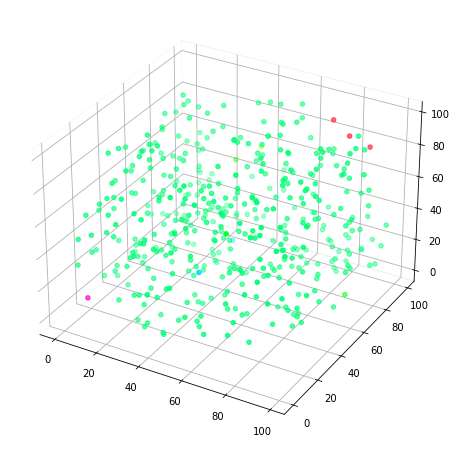

In [35]:
fig = plt.figure(figsize = (16, 8))
ax = plt.axes(projection ="3d")
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
my_cmap = plt.get_cmap("gist_rainbow_r")
ax.scatter3D(test_hierarchical["x"], 
             test_hierarchical["y"], 
             test_hierarchical["z"], 
             cmap = my_cmap, 
             c = (test_hierarchical["cy"] + test_hierarchical["cz"] + test_hierarchical["cx"])) 

The plot seems a little bit odd, but we will address the reasons later on conclusion

And calculate the silhouette coefficient

In [36]:
test_hierarchical_silhouette = calculate_silhouette(test_hierarchical.copy())
test_hierarchical_silhouette.tail()

,x,y,z,potential_outlier,cx,cy,cz,silhouette_coeficient
495,24,45,69,False,49.946309,50.516779,48.017897,-0.687330
496,99,23,40,False,49.946309,50.516779,48.017897,-0.370126
497,30,77,82,False,49.946309,50.516779,48.017897,-0.571527
498,6,27,88,False,49.946309,50.516779,48.017897,-0.352834
499,10,64,91,False,49.946309,50.516779,48.017897,-0.451365


In [37]:
sum(test_hierarchical_silhouette["silhouette_coeficient"]) / len(test_hierarchical_silhouette.index)

-0.4636241604514838

# Putting everything together

Let's generate a new set of data points to work with a fresh dataset

In [38]:
test = np.random.randint(0, 100, size=(500, 3))
test = pd.DataFrame(test, columns = ["x", "y", "z"])

And start by creating a function to plot the data points, with or without clustering

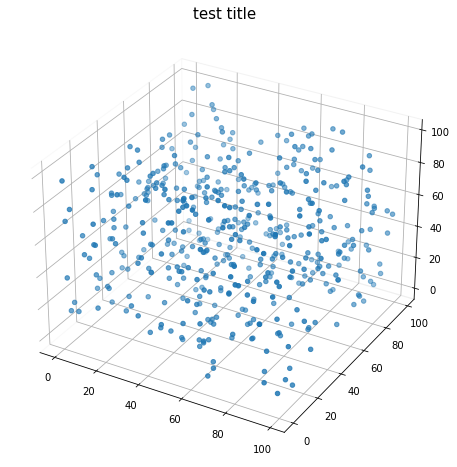

In [39]:
def plot_data_points(data_points, chart_title = None):
    fig = plt.figure(figsize = (16, 8))
    ax = plt.axes(projection ="3d")
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    my_cmap = plt.get_cmap("gist_rainbow_r")
    if "cy" in data_points.columns:
        ax.scatter3D(data_points["x"], data_points["y"], data_points["z"], 
             cmap = my_cmap, c = (data_points["cy"] + data_points["cz"] + data_points["cx"])) 
    else:
        ax.scatter3D(data_points["x"], data_points["y"], data_points["z"])
    if chart_title is not None:
        plt.title(chart_title, size=15)
        
plot_data_points(test.copy(), "test title")

And another function to plot the outliers

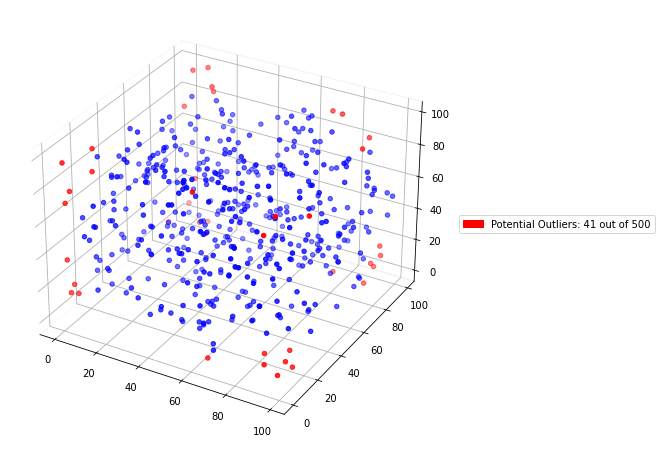

In [40]:
def plot_outliers(data_points, d_distance = 100, p_fraction = 0.15, chart_title = None):
    outliers = DB_outlier_detection(data_points.values.tolist(), d_distance = 50, p_fraction = 0.15)
    outliers = pd.DataFrame(outliers, columns = ["coordinates", "potential_outlier"])
    outliers["coordinates_str"] = [','.join(map(str, l)) for l in outliers["coordinates"]]
    outliers[["x", "y", "z"]] = outliers["coordinates_str"].str.split(",", expand=True)
    outliers[["x", "y", "z"]] = outliers[["x", "y", "z"]].apply(pd.to_numeric)
    outliers = outliers[["x", "y", "z", "potential_outlier"]]
    outliers["color"] = outliers["potential_outlier"].apply(lambda row: "Red" if row else "Blue")
    
    fig = plt.figure(figsize = (16, 8))
    ax = plt.axes(projection ="3d")
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.scatter3D(outliers["x"], outliers["y"], outliers["z"], facecolors = outliers["color"])
    outlier_label = (
        "Potential Outliers: " + 
        str(len(outliers[outliers["potential_outlier"] == True])) + 
        " out of " + 
        str(len(outliers))
    )
    red_patch = mpatches.Patch(color="red", label=outlier_label)
    ax.legend(handles=[red_patch], bbox_to_anchor=(1.5, .5), loc="center right")
    if chart_title is not None:
        plt.title(chart_title, size=15)    
    
plot_outliers(test.copy(), 50, .15)

Finally, we create a function to perform all the activities developed:

1. Remove outliers
2. Generate K-means clustering and calculate its silhouette
3. Initialize the distances Pandas DataFrame
4. Generate the Hierarchical Agglomerative clustering using nearest, farthest, average and center measures and calculate their silhouette

This function receives:

* **data_points**: a list of 3-D vectors containing all datapoints
* **d_distance**: the distance threshold to be used for outliers detection
* **p_fraction**: the fraction of neighbors to be considered in the radius for outliers detection
* **k**: the number of clusters to be generated

and generates a Pandas DataFrame comparing the silhoutte coefficient for the five clustering (K-means and Hierarchical Agglomerative using the four distance types). It also plots the following charts before outputs the Pandas DataFrame:

* The initial data points
* The data points with the outliers annotated
* All the five clustering results

In [41]:
def clustering_analysis(data_points, d_distance = 100, p_fraction = 0.15, k = 10):
    plot_data_points(data_points, "Initial Data Points")
    plot_outliers(data_points, d_distance, p_fraction, "Outliers Detection")
    data_points = remove_outliers(data_points.copy(), d_distance = d_distance, p_fraction = p_fraction)
    data_points_kmeans = k_means(data_points.copy(), k)
    plot_data_points(data_points_kmeans, chart_title = "K-Means clustering")
    data_points_kmeans_silhouette = calculate_silhouette(data_points_kmeans.copy())

    clear_output()
    print("Initializing distances DataFrame")
    distances = initialize_distances(data_points.copy())

    data_points_hierarchical_min = hierarchical_agglomerative(
        data_points.copy(), k, distance_type = "min", distances = distances.copy())
    plot_data_points(
        data_points_hierarchical_min.copy(), 
        chart_title = "Hierarchical Agglomerative clustering\nusing distance between nearest two points")
    data_points_hierarchical_min_silhouette = calculate_silhouette(
        data_points_hierarchical_min.copy())

    data_points_hierarchical_max = hierarchical_agglomerative(
        data_points.copy(), k, distance_type = "max", distances = distances.copy())
    plot_data_points(
        data_points_hierarchical_max, 
        chart_title = "Hierarchical Agglomerative clustering\nusing distance between farthest two points")
    data_points_hierarchical_max_silhouette = calculate_silhouette(data_points_hierarchical_max.copy())

    data_points_hierarchical_avg = hierarchical_agglomerative(
        data_points.copy(), k, distance_type = "avg", distances = distances.copy())
    plot_data_points(
        data_points_hierarchical_avg, 
        chart_title = "Hierarchical Agglomerative clustering\nusing average distance between clusters")
    data_points_hierarchical_avg_silhouette = calculate_silhouette(data_points_hierarchical_avg.copy())

    data_points_hierarchical_center = hierarchical_agglomerative(
        data_points.copy(), k, distance_type = "center", distances = distances.copy())
    plot_data_points(
        data_points_hierarchical_center, 
        chart_title = "Hierarchical Agglomerative clustering\nusing distance between the center of clusters")
    data_points_hierarchical_center_silhouette = calculate_silhouette(data_points_hierarchical_center.copy())

    clear_output()    
    result = []
    result.append({
        "method": "K-means",
        "silhouette": (sum(data_points_kmeans_silhouette["silhouette_coeficient"]) / 
                       len(data_points_kmeans_silhouette.index))
    })
    
    result.append({
        "method": "Hierarchical Agglomerative using nearest distance between clusters",
        "silhouette": (sum(data_points_hierarchical_min_silhouette["silhouette_coeficient"]) / 
                       len(data_points_hierarchical_min_silhouette.index))
    })    
    
    result.append({
        "method": "Hierarchical Agglomerative using farthest distance between clusters",
        "silhouette": (sum(data_points_hierarchical_max_silhouette["silhouette_coeficient"]) / 
                       len(data_points_hierarchical_max_silhouette.index))
    })    

    result.append({
        "method": "Hierarchical Agglomerative using average distance between clusters",
        "silhouette": (sum(data_points_hierarchical_avg_silhouette["silhouette_coeficient"]) / 
                       len(data_points_hierarchical_avg_silhouette.index))
    })    

    result.append({
        "method": "Hierarchical Agglomerative using cluster center distance",
        "silhouette": (sum(data_points_hierarchical_center_silhouette["silhouette_coeficient"]) / 
                       len(data_points_hierarchical_center_silhouette.index))
    })    

    return pd.DataFrame(result)

From now on, we conduct experiments using fresh new datasets and we also change the parameters (d, p and k) for each one of them

# Experiment \#1

For this experiment we use the same parameters we were using so far:

* d_distance = 50
* p_fraction = 0.15
* k = 10

,method,silhouette
0,K-means,0.271881
4,Hierarchical Agglomerative using cluster cente...,0.263480
3,Hierarchical Agglomerative using average dista...,0.247908
2,Hierarchical Agglomerative using farthest dist...,0.228515
1,Hierarchical Agglomerative using nearest dista...,-0.233521


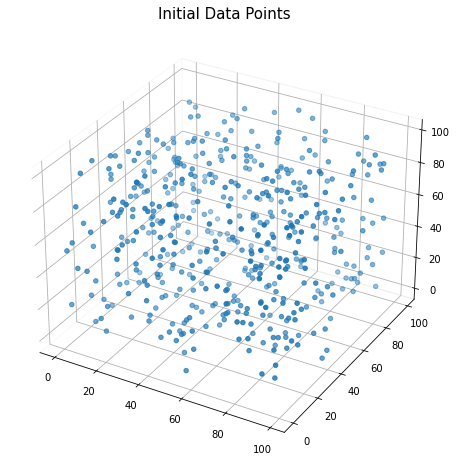

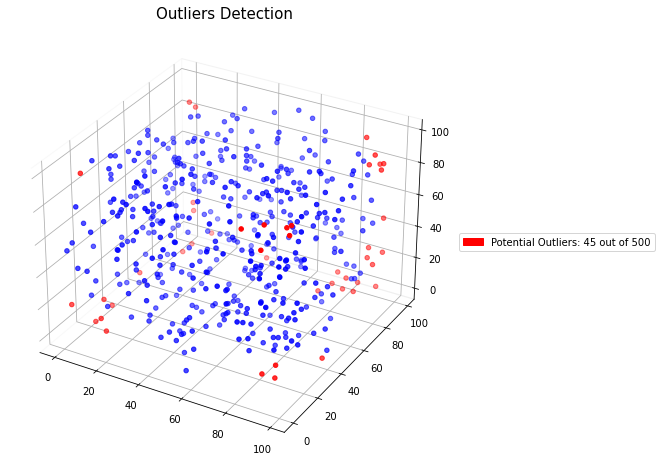

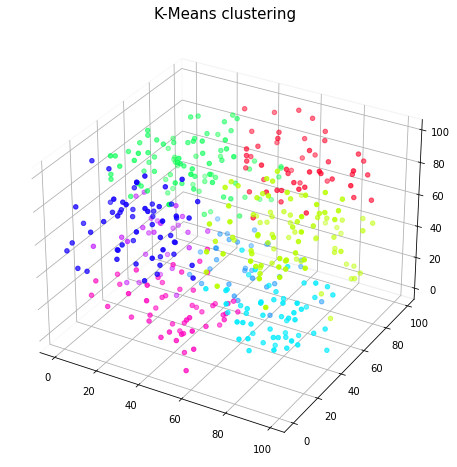

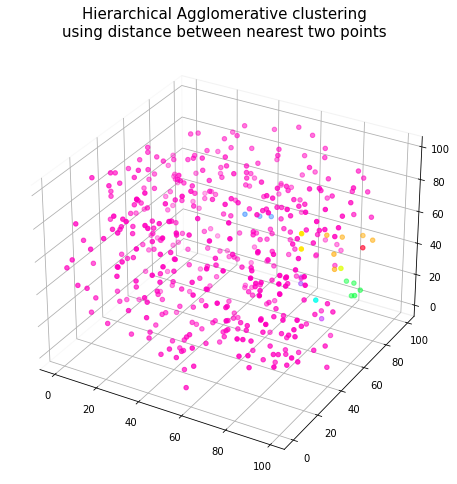

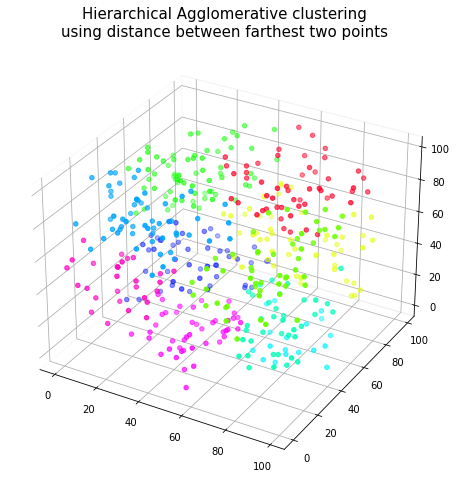

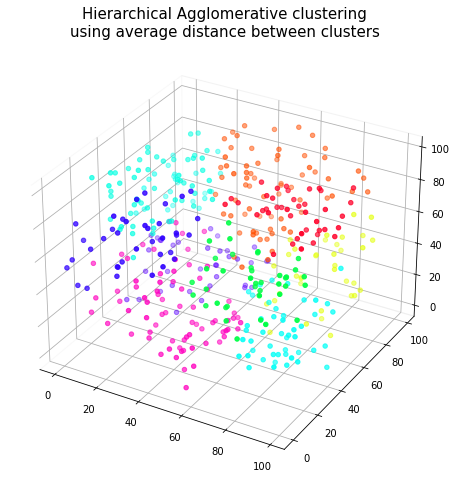

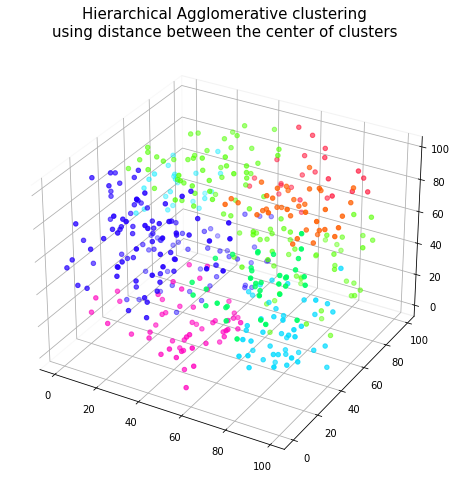

In [42]:
experiment_1 = np.random.randint(0, 100, size=(500, 3))
experiment_1 = pd.DataFrame(experiment_1, columns = ["x", "y", "z"])
experiment_1 = clustering_analysis(experiment_1.copy(), d_distance = 50, p_fraction = 0.15, k = 10)
experiment_1.sort_values(by=["silhouette"], ascending=False)

# Experiment \#2

For this experiment we use the same parameters we were using so far:

* d_distance = 40
* p_fraction = 0.11
* k = 6

,method,silhouette
0,K-means,0.303377
4,Hierarchical Agglomerative using cluster cente...,0.254463
3,Hierarchical Agglomerative using average dista...,0.240650
2,Hierarchical Agglomerative using farthest dist...,0.195810
1,Hierarchical Agglomerative using nearest dista...,-0.224824


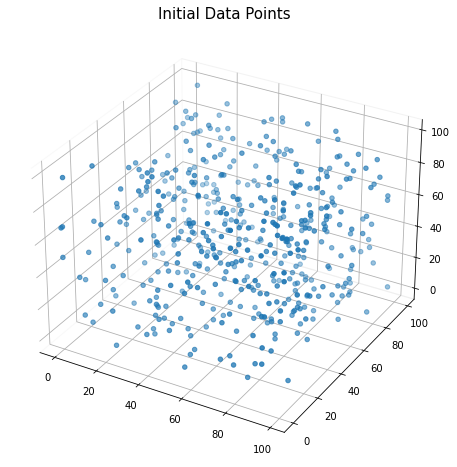

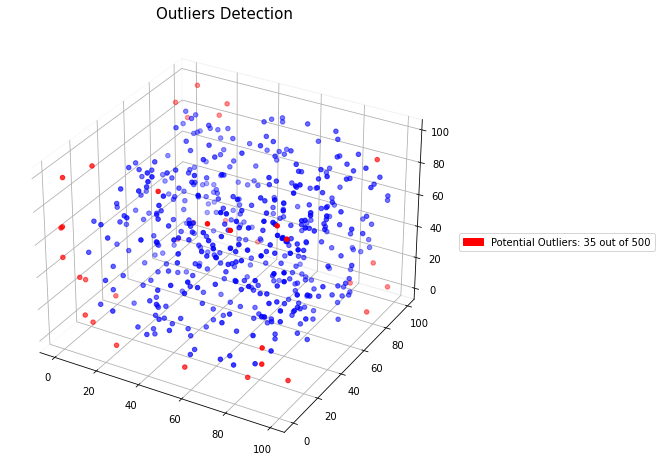

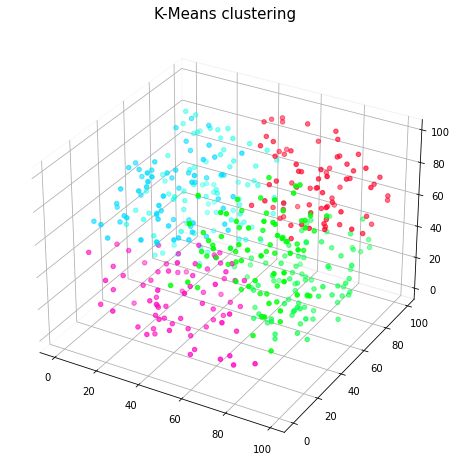

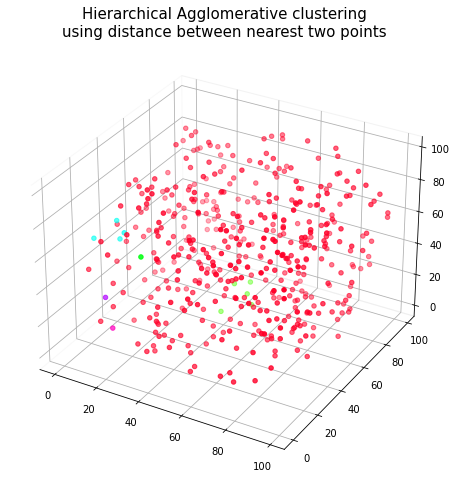

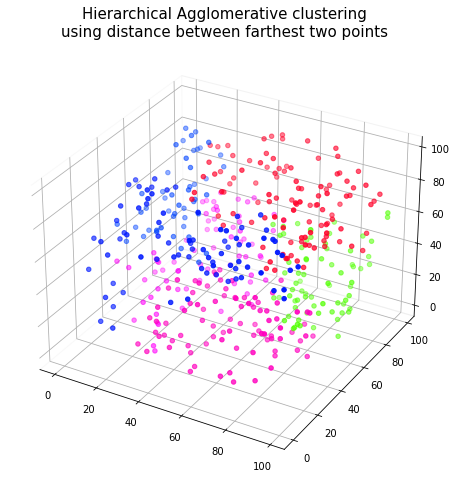

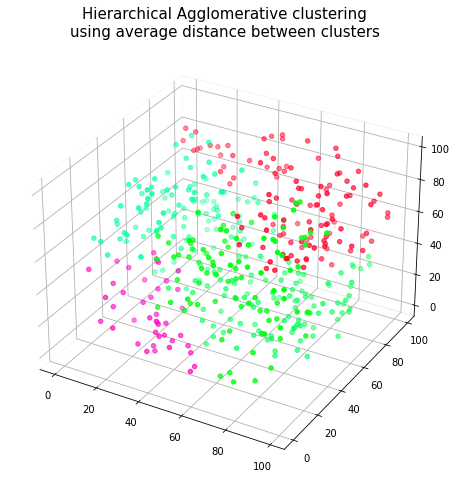

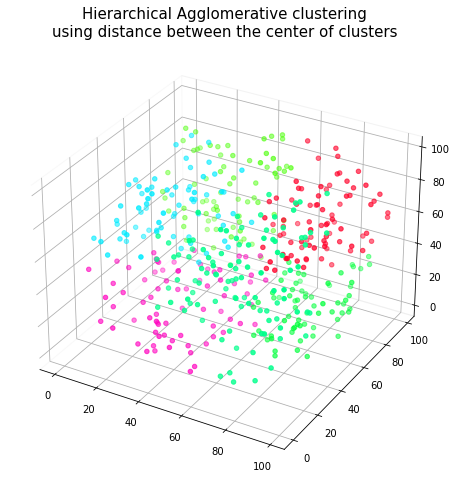

In [43]:
experiment_2 = np.random.randint(0, 100, size=(500, 3))
experiment_2 = pd.DataFrame(experiment_2, columns = ["x", "y", "z"])
experiment_2 = clustering_analysis(experiment_2.copy(), d_distance = 40, p_fraction = 0.11, k = 6)
experiment_2.sort_values(by=["silhouette"], ascending=False)

# Experiment \#3

For this experiment we use the same parameters we were using so far:

* d_distance = 60
* p_fraction = 0.2
* k = 14

,method,silhouette
0,K-means,0.256358
3,Hierarchical Agglomerative using average dista...,0.256118
4,Hierarchical Agglomerative using cluster cente...,0.216344
2,Hierarchical Agglomerative using farthest dist...,0.192505
1,Hierarchical Agglomerative using nearest dista...,-0.480583


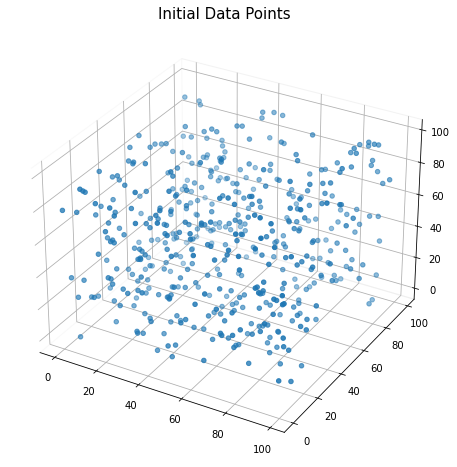

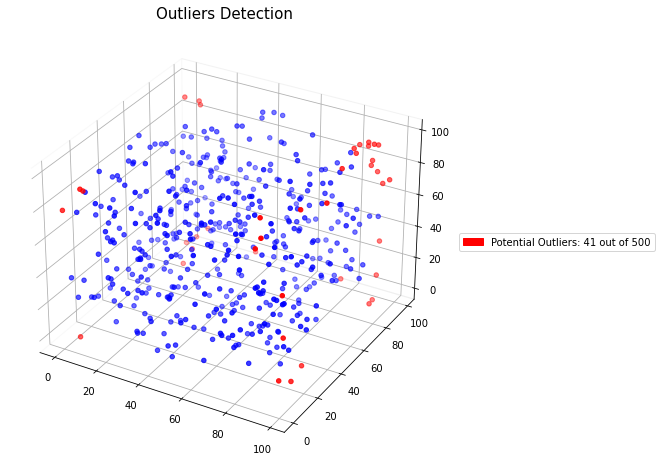

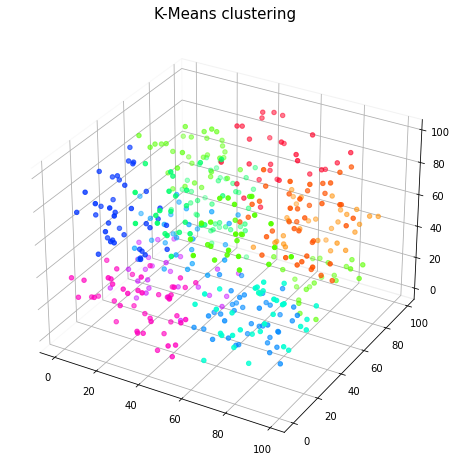

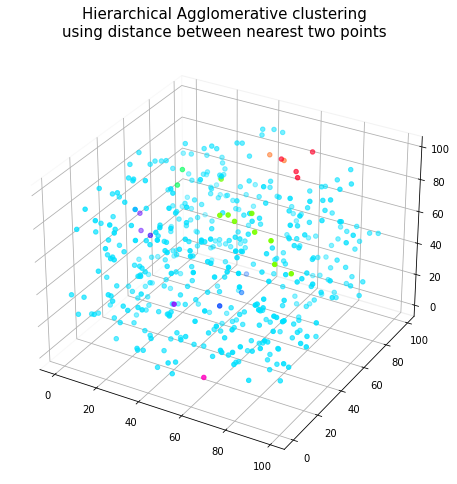

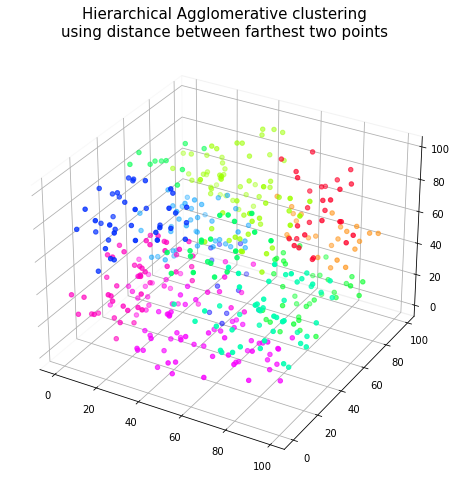

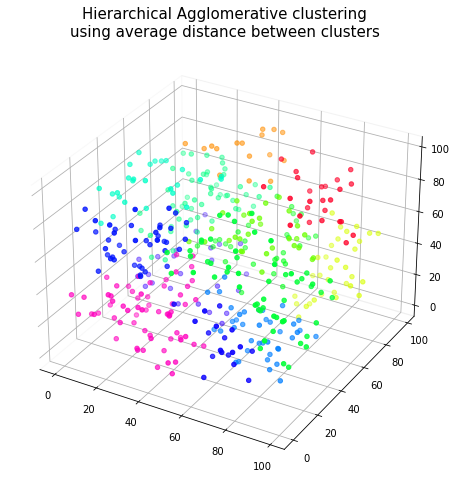

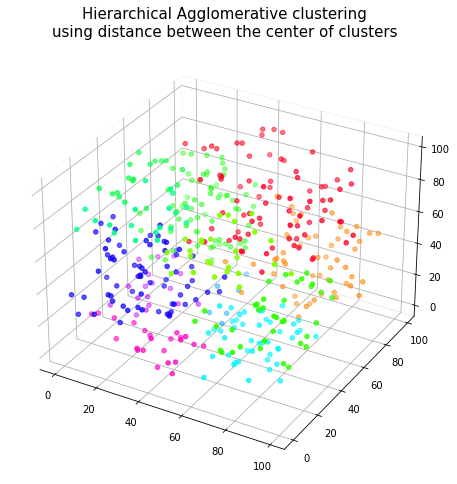

In [44]:
experiment_3 = np.random.randint(0, 100, size=(500, 3))
experiment_3 = pd.DataFrame(experiment_3, columns = ["x", "y", "z"])
experiment_3 = clustering_analysis(experiment_3.copy(), d_distance = 60, p_fraction = 0.2, k = 14)
experiment_3.sort_values(by=["silhouette"], ascending=False)

# Conclusion

As we can see not just during the experiments, but as well during the development of the program above, K-means is always better for this type of data set, than Hierarchical Agglomerative. This is probably caused because K-means keeps re-assigning the data points to their closest clusters at each round, while Agglomerative keeps them into the first cluster they were assigned to, with no "re-calibration".

Another factor we noticed is that the higher the K used in K-means, the higher the time taken to process and rounds to converge. This may not be noticed in the examples above, with K only between 5 and 15, but during the development we have tested with K up to 50 clusters and the trend line for time and rounds always goes up with K.

On the other hand, Hierarchical Agglomerative has an opposite trend: the higher the K, the lower the time to conclude. This is caused mainly because K in this case acts somehow as an early-stop in agglomerating.

With these two observations, we can say that, although K-means always performed better than Hierarchical Agglomerative, the resources used may be a decision factor and one may decide between the trade-off of K-means better clustering vs Hierarchical Agglomerative speed (for high number of K=clusters).

On Hierarchical Agglomerative, we came to the conclusion that the min distance is the worse for this type of dataset, because it usually keeps agglomerating to an existing cluster for this amount of data points. That is why on the plots almost all data points belong to one cluster while the rest of them form clusters of very few data points.

The other types of distances generated clusters with good silhouette coefficients (at least above 0), with one or another being better than others, depending on the data points randomly generated and the parameters for outlier detection and the number of clusters. One thing to notice is that for small number of data points, sometimes two of them (and sometimes even the three of them) converged to the same clustering. That never happened with min distance, though.